In [1]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d


In [2]:
# import all the s2p files in Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA
import os
import glob
# path = 'Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA'
# s2p_files = glob.glob(os.path.join(path, '*.s2p'))

update = True
update = False

update_gain = True
update_gain = False

# aug_4 = True
# aug_4 = False

In [3]:
# grab all files from both directories
# if aug_4:
HPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA'
VPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_VPOL_VNA'
s2p_files_HPol = glob.glob(os.path.join(HPol_path, '*.s2p'))
s2p_files_VPol = glob.glob(os.path.join(VPol_path, '*.s2p'))
# Load all s2p files into a single list of Network objects
networks_aug_4 = [rf.Network(file) for file in s2p_files_HPol + s2p_files_VPol]
networks_aug_4 = sorted(networks_aug_4, key=lambda x: (x.name[:-2], int(x.name[-2:]) if x.name[-2:].isdigit() else float('inf')))

# else:
path = 'Data/Full Set/020825/Port1inNEhole_Port2inShole_ST25_VNA'
s2p_files_full = glob.glob(os.path.join(path, '*.s2p'))
networks_aug_2 = [rf.Network(file) for file in s2p_files_full]
networks_aug_2 = sorted(networks_aug_2, key=lambda x: (x.name[:-2], int(x.name[-2:]) if x.name[-2:].isdigit() else float('inf')))

d = 34.63  # Distance according to station json file in meters
# TODO: figure out which is the correct distance to use
# the json method assumes that the NRMC coord system is in meters and the layour is an equilateral triangle

In [4]:
dir = 'Gain Plots/'

if update_gain:
    for net in networks_aug_4:
        # print(net.name)
        # if net.name != 'Aug4_hpol_down_25m':
        #     continue  # Skip this network for now
        plt.figure(figsize=(10, 4))

        # calculate the gain of the antenna from the S12 parameter
        wavelength = 3e8 / net.f  # Wavelength in meters
        G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])


        smoothed_G_i = gaussian_filter1d(G_i, sigma=20)  # Smooth the gain
        # plot the gain
        plt.plot(net.f, 10 * np.log10(G_i), label=net.name, linewidth=0.3)
        plt.plot(net.f, 10 * np.log10(smoothed_G_i), label=net.name + ' (smoothed)', linewidth=1)
        plt.title('Gain of Antenna from S12 Parameter')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain (dB)')
        plt.grid()
        # plt.savefig(f'{dir}{net.name[5:]}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{dir}{net.name}.png', dpi=300, bbox_inches='tight')
        plt.close()

In [5]:
# Constants we know
Z_f = 377  # Free space impedance in Ohms
# n = 1.32  # Refractive index of the medium (Greenland Firn)
Z_0 = 50.0  # Characteristic impedance of the antenna in Ohms

In [6]:
def get_RVEL(network, G_i):
    wavelength = 3e8 / network.f  # Wavelength in meters
    RVEL = wavelength * np.sqrt(((Z_0) / (4 * np.pi * Z_f)) * G_i)  # Antenna impedance calculation

    return RVEL

In [7]:
# load the NuRadioMC VELS data
import pickle
from NuRadioReco.utilities import units

with open('NuRadio_VELS_dict.pkl', 'rb') as f:
    NuRadio_VELS_dict = pickle.load(f)

In [8]:
dir = 'RVEL Plots/'
ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)
RVEL_sigma = 30

# update = True

if update:
    for net in networks_aug_4:
        # if net.name != 'Aug4_hpol_down_25m':
        # if net.name != 'Aug4_vpol_down_1m':
        #     continue

        # print(net.name)

        wavelength = 3e8 / net.f  # Wavelength in meters
        G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])
        RVEL = get_RVEL(net, G_i)
        smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)  #

        plt.figure(figsize=(10, 4))
        # plt.plot(net.f, RVEL, label=net.name, linewidth=0.3)
        plt.plot(net.f, smoothed_RVEL, label=net.name + ' (smoothed)', linewidth=1)
        # plt.plot(ff / units.Hz, NuRadio_VELS['theta'], label='NuRadioMC VELS', linewidth=1)

        if net.name[5:6] == 'h':
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)

        else:
            # NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1)


        plt.title(f'RVEL for {net.name}')
        plt.xlabel('Frequency (Hz)')
        # plt.xlim(.08e9, 1e9)
        plt.ylabel('RVEL (m)')
        # plt.ylim(0, 0.2)  # Set y-axis limits to focus on the RVEL


        plt.grid()
        plt.legend()
        # plt.savefig(f'{dir}{net.name[5:]}_RVEL.png', dpi=300, bbox_inches='tight')
        # plt.savefig(f'{dir}{net.name}_RVEL.png', dpi=300, bbox_inches='tight')

        plt.close()

        plt.figure(figsize=(10, 4))
        # plt.figure(figsize=(8, 6))

        # plt.plot(net.f, RVEL, label=net.name, linewidth=0.3)
        plt.plot(net.f, RVEL, label=net.name + ' RVEL', linewidth=0.5)
        plt.plot(net.f, smoothed_RVEL, label=net.name + ' RVEL (smoothed)', linewidth=1, color='red')
        # plt.plot(ff / units.Hz, NuRadio_VELS['theta'], label='NuRadioMC VELS', linewidth=1)


        if 'hpol' in net.name:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVEL', linewidth=1)
            plt.ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
            print(f'hpol: {net.name}')
        else:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVEL', linewidth=1)
            plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
            print('not hpol')

        plt.title(f'RVEL for {net.name}')
        plt.xlabel('Frequency (Hz)')
        # plt.xlim(.08e9, 1e9)
        plt.ylabel('RVEL (m)')
        # plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        plt.grid()
        plt.legend()
        # plt.savefig(f'{dir}{net.name[5:]}_RVEL_zoomed.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{dir}{net.name}_RVEL_zoomed.png', dpi=300, bbox_inches='tight')
        # plt.savefig(f'{dir}{net.name[5:]}_RVEL_zoomed_4x3.png', dpi=300, bbox_inches='tight')

        plt.close()


In [9]:

ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)

# sort the networks by name
# networks = sorted(networks, key=lambda x: x.name)
num_networks = len(networks_aug_4)
print(f'Number of networks: {num_networks}')


hpol_down_networks_aug_4 = [net for net in networks_aug_4 if 'hpol_down' in net.name]
hpol_up_networks_aug_4 = [net for net in networks_aug_4 if 'hpol_up' in net.name]
vpol_networks_aug_4 = [net for net in networks_aug_4 if 'vpol' in net.name]


vpol_networks_aug_2 = networks_aug_2

# print(len(hpol_down_networks_aug_4), len(vpol_networks_aug_4))

# make an array of the networks that are hpol down, their name, wavelength, Gain, and RVEL
hpol_down_aug_4 = []
RVEL_sigma = 30

for i, net in enumerate(hpol_down_networks_aug_4):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=RVEL_sigma)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=RVEL_sigma)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)
    hpol_down_aug_4.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })

hpol_up_aug_4 = []
for i, net in enumerate(hpol_up_networks_aug_4):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=RVEL_sigma)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=RVEL_sigma)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)
    hpol_up_aug_4.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })

vpol_aug_4 = []
for i, net in enumerate(vpol_networks_aug_4):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=RVEL_sigma)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=RVEL_sigma)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)
    vpol_aug_4.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })

vpol_aug_2 = []
for i, net in enumerate(vpol_networks_aug_2):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=RVEL_sigma)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=RVEL_sigma)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)
    vpol_aug_2.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })


# print the first three names of the hpol_down networks
for net in hpol_down_networks_aug_4[:3]:
    print(net.name)
for net in vpol_networks_aug_2[:3]:
    print(net.name)

Number of networks: 99
Aug4_hpol_down_1m
Aug4_hpol_down_2m
Aug4_hpol_down_3m
aug2_2m
aug2_3m
aug2_4m


In [10]:
# create a plot with 2 columns and plot the RVEL for aug2 on the left and aug4 in right column for the first three vpol antennas

# length = max(len(vpol_aug_2), len(vpol_aug_4))
# print(f'len(vpol_aug_2): {len(vpol_aug_2)}, len(vpol_aug_4): {len(vpol_aug_4)}')
length = 37

if update:
    # fig, axs = plt.subplots(4, 2, figsize=(20, 4 * 3), sharex=True)
    fig, axs = plt.subplots(length-1, 2, figsize=(20, length * 3), sharex=True)
    # for i in range(4):
    for i in range(length - 1):
        # print(f'Plotting for {i}')

        net_aug_2 = vpol_aug_2[i]
        net_aug_4 = vpol_aug_4[i+1]
        name_aug_2 = net_aug_2['name']
        name_aug_4 = net_aug_4['name']
        # print(f'i = {i}, name aug 2: {name_aug_2}, name aug 4: {name_aug_4}')

        axs[i, 0].plot(net_aug_2['frequency'], net_aug_2['RVEL'], label='ST25 RVEL', linewidth=0.3)
        axs[i, 0].plot(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], label='ST25 RVEL (smoothed)', linewidth=1, color='red')
        axs[i, 1].plot(net_aug_4['frequency'], net_aug_4['RVEL'], label='ST35 RVEL', linewidth=0.3)
        axs[i, 1].plot(net_aug_4['frequency'], net_aug_4['smoothed_RVEL'], label='ST35 RVEL (smoothed)', linewidth=1, color='red')
        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
        axs[i, 0].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')
        axs[i, 1].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')

        axs[i, 0].set_title(f'RVEL for station 25 at depth {name_aug_2.split("_")[-1]}')
        axs[i, 1].set_title(f'RVEL for station 35 at depth {name_aug_4.split("_")[-1]}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i, 0].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i, 1].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i, 0].set_xlim(0, 1e9)
        axs[i, 1].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i, 0].set_xlabel('Frequency (Hz)')
        axs[i, 1].set_xlabel('Frequency (Hz)')
        axs[i, 0].set_ylabel('RVEL (m)')
        axs[i, 1].set_ylabel('RVEL (m)')
        axs[i, 0].tick_params(axis='x', which='both', labelbottom=True)
        axs[i, 1].tick_params(axis='x', which='both', labelbottom=True)
        axs[i, 0].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i, 1].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i, 0].grid()
        axs[i, 1].grid()
        axs[i, 0].legend()
        axs[i, 1].legend()
    plt.tight_layout()

    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL all depths.pdf', dpi=300, bbox_inches='tight')


In [11]:
# repeat the above but overlay the two RVELs on the same plot for each depth
if update:
    fig, axs = plt.subplots(length-1, 1, figsize=(10, length * 3), sharex=True)
    # for i in range(4):
    for i in range(length - 1):
        # print(f'Plotting for {i}')

        net_aug_2 = vpol_aug_2[i]
        net_aug_4 = vpol_aug_4[i+1]
        name_aug_2 = net_aug_2['name']
        name_aug_4 = net_aug_4['name']

        # axs[i].plot(net_aug_2['frequency'], net_aug_2['RVEL'], label=net_aug_2['name'] + ' RVEL', linewidth=0.3)
        axs[i].plot(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], label='ST25 RVEL', linewidth=1, color='green')
        # axs[i].plot(net_aug_4['frequency'], net_aug_4['RVEL'], label=net_aug_4['name'] + ' RVEL', linewidth=0.3)
        axs[i].plot(net_aug_4['frequency'], net_aug_4['smoothed_RVEL'], label='ST35 RVEL', linewidth=1, color='blue')

        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
        axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')
        axs[i].set_title(f'RVEL for Station 25 and 35 at depth {name_aug_2.split("_")[-1]}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        axs[i].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()
    plt.tight_layout()
    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL all depths overlayed.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL all depths overlayed.png', dpi=300, bbox_inches='tight')


In [12]:
# repeat the above but only for every n network
n = 5
print(f'lenght: {length}, (length-1)//n + 1: {(length-1)//n + 1}')

if not update:
    fig, axs = plt.subplots((length-1)//n + 1, 1, figsize=(10, ((length-1)//n + 1) * 3), sharex=True)
    # for i in range(4):
    for i in range(0, 8):
        # print(f'Plotting for {i}')
        itter = i * n
        print(f'Plotting for {i}, itter: {itter}')
        net_aug_2 = vpol_aug_2[itter]
        net_aug_4 = vpol_aug_4[itter+1]
        name_aug_2 = net_aug_2['name']
        name_aug_4 = net_aug_4['name']

        # axs[i].plot(net_aug_2['frequency'], net_aug_2['RVEL'], label=net_aug_2['name'] + ' RVEL', linewidth=0.3)
        axs[i].plot(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], label='ST25 RVEL', linewidth=1, color='green')
        # axs[i].plot(net_aug_4['frequency'], net_aug_4['RVEL'], label=net_aug_4['name'] + ' RVEL', linewidth=0.3)
        axs[i].plot(net_aug_4['frequency'], net_aug_4['smoothed_RVEL'], label='ST35 RVEL', linewidth=1, color='blue')

        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
        axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')
        axs[i].set_title(f'RVEL for Station 25 and 35 at depth {name_aug_2.split("_")[-1]} {name_aug_4.split("_")[-1]}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        axs[i].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()
    plt.tight_layout()
    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL all depths overlayed - every {n}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL all depths overlayed - every {n}.png', dpi=300, bbox_inches='tight')
    plt.close()

lenght: 37, (length-1)//n + 1: 8
Plotting for 0, itter: 0
Plotting for 1, itter: 5
Plotting for 2, itter: 10
Plotting for 3, itter: 15
Plotting for 4, itter: 20
Plotting for 5, itter: 25
Plotting for 6, itter: 30
Plotting for 7, itter: 35


In [13]:
# plot each of the 50 hpol down files in a column of subplots
dir = 'RVEL Plots'

smoothing = False

# network_list = hpol_down
# network_list = hpol_up
network_list1 = vpol_aug_4
network_list2 = vpol_aug_2

length = max(len(network_list1), len(network_list2))
print(length)

vpol_peaks = []

if update:
    ### fig, axs = plt.subplots(len(network_list1), 1, figsize=(10, 3 * len(network_list1)), sharex=True)
    #fig, axs = plt.subplots(length, 2, figsize=(10, 3 * length), sharex=True)
    fig, axs = plt.subplots(3, 2, figsize=(10, 3 * 3), sharex=True)
    for i, net in enumerate(network_list1):
        if i > 2:
            break
        # name = net['name'][5:]  # remove the Aug4_ part of the name
        name = net['name']

        # print(f'Plotting for {name}')
        if not smoothing:
            axs[i].plot(net['frequency'], net['RVEL'], label=net['name'] + ' RVEL', linewidth=1)

        axs[i].plot(net['frequency'], net['smoothed_RVEL'], label=net['name'] + ' RVEL (smoothed)', linewidth=1, color='red')
        # else:
        # plot the NuRadioMC RVELs
        if 'hpol' in name:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        else:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
            axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1)
            # find the peak VNA RVEL above 100 MHz and draw a vertical line there with a label for the frequency
            peak_index = np.argmax(net['smoothed_RVEL'][net['frequency'] >= 100e6])
            peak_freq = net['frequency'][net['frequency'] >= 100e6][peak_index]
            peak_RVEL = net['smoothed_RVEL'][net['frequency'] >= 100e6][peak_index]
            axs[i].axvline(peak_freq, color='blue', linestyle='--', label=f'Peak VNA RVEL at {peak_freq/1e6:.1f} MHz', alpha=0.3)
            vpol_peaks.append((name, peak_freq, peak_RVEL))

            # find the peak NuRadio RVEL above 100 MHz and draw a vertical line there with a label for the frequency
            peak_index_nu = np.argmax(np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz]))
            peak_freq_nu = ff[ff >= 100 * units.MHz][peak_index_nu] / units.Hz
            peak_RVEL_nu = np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz][peak_index_nu])
            axs[i].axvline(peak_freq_nu, color='orange', linestyle='--', label=f'Peak NuRadio RVEL at {peak_freq_nu/1e6:.1f} MHz', alpha=0.7)



        axs[i].set_title(f'RVEL for {name}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        if 'hpol' in name:
            axs[i].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        else:
            axs[i].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()

    # axs[-1].set_xlabel('Frequency (Hz)')
    plt.tight_layout()


    # if smoothing:
        # plt.savefig(f'{dir}/all {name}_RVEL_smoothed.png', dpi=300, bbox_inches='tight')
    # else:
        # plt.savefig(f'{dir}/all {name}_RVEL.png', dpi=300, bbox_inches='tight')
        # plt.savefig(f'{dir}/all {name}_RVEL.pdf', dpi=300, bbox_inches='tight')

    # plt.close()

52


In [14]:
# calculate the area under the two curves between 100 MHz and 600 MHz for each depth and plot the difference
# lower_frq = 300e6
# upper_frq = 400e6
length = min(len(vpol_aug_2), len(vpol_aug_4))  # make sure we don't go out of bounds

# depths = the depths which appear in both lists
depths_aug_2 = []
depths_aug_4 = []
for net in vpol_aug_2:
    depth = int(net['name'].split('_')[-1][:-1])  # get the depth in meters as an integer
    depths_aug_2.append(depth)
for net in vpol_aug_4:
    depth = int(net['name'].split('_')[-1][:-1])  # get the depth in meters as an integer
    depths_aug_4.append(depth)
# find the depths which appear in both lists
depths = list(set(depths_aug_2) & set(depths_aug_4))
depths.sort()
# print the first and last depths
print(f'Depths: {depths[0]} m to {depths[-1]} m')

# lower_frqs = 100e6 to 800e6 in steps of 100e6
lower_frqs = np.arange(100e6, 300e6, 100e6)
upper_frqs = np.arange(200e6, 400e6, 100e6)
print(upper_frqs)

for lower_frq in lower_frqs:
    for upper_frq in upper_frqs:
        if upper_frq <= lower_frq:
            continue
        print(f"lower: {lower_frq/1e6} MHz, upper: {upper_frq/1e6} MHz")

        # mags_aug_2 = []
        # mags_aug_4 = []
        ave_mags_aug_2 = []
        ave_mags_aug_4 = []
        frq_range = upper_frq - lower_frq
        # print(length)

        for i in range(length -1):
            net_aug_2 = vpol_aug_2[i]
            net_aug_4 = vpol_aug_4[i+1]
            # print(f'Calculating area for {net_aug_2["name"]} and {net_aug_4["name"]}')

            # integrate using the trapezoidal rule
            area_aug_2 = np.trapezoid(net_aug_2['smoothed_RVEL'][(net_aug_2['frequency'] >= lower_frq) & (net_aug_2['frequency'] <= upper_frq)],
                                      net_aug_2['frequency'][(net_aug_2['frequency'] >= lower_frq) & (net_aug_2['frequency'] <= upper_frq)])
            area_aug_4 = np.trapezoid(net_aug_4['smoothed_RVEL'][(net_aug_4['frequency'] >= lower_frq) & (net_aug_4['frequency'] <= upper_frq)],
                                      net_aug_4['frequency'][(net_aug_4['frequency'] >= lower_frq) & (net_aug_4['frequency'] <= upper_frq)])

            # mags_aug_2.append(area_aug_2)
            # mags_aug_4.append(area_aug_4)
            ave_mags_aug_2.append(area_aug_2 / frq_range)
            ave_mags_aug_4.append(area_aug_4 / frq_range)
            percent = (ave_mags_aug_2[i] - ave_mags_aug_4[i]) / ((ave_mags_aug_2[i] + ave_mags_aug_4[i]) / 2) * 100
            print(f"Depth: {depths[i]} m, ST25 Ave RVEL: {ave_mags_aug_2[-1]:.4f} m, ST35 Ave RVEL: {ave_mags_aug_4[-1]:.4f} m, Percent Difference: {percent:.2f}%")



        mag_diffs = np.array(ave_mags_aug_4) - np.array(ave_mags_aug_2)
        ave_mag_sums = np.array(ave_mags_aug_4) + np.array(ave_mags_aug_2)
        percents = mag_diffs / (ave_mag_sums/2) * 100
        plt.figure(figsize=(10, 4))
        plt.plot(depths, mag_diffs, label='Average RVEL Difference (ST35 - ST25)', marker='o')
        plt.title(f'Average RVEL Difference between ST35 and ST25 RVEL vs Depth\n({lower_frq/1e6}MHz to {upper_frq/1e6}MHz), VPol')
        # write the percentages above each point
        for j, percent in enumerate(percents):
            plt.text(depths[j], mag_diffs[j]+0.001, f'{percent:.1f}%', fontsize=8, ha='center', va='bottom')
        # add text to the bottom of the plot
        plt.xlabel('Depth (m)')
        plt.ylabel('Average RVEL Difference (m)')
        plt.grid()
        plt.legend()
        plt.savefig(f'{dir}/ST35 and ST25 Ave RVEL vs depth {lower_frq/1e6}MHz to {upper_frq/1e6}MHz - vpol_down.png', dpi=300, bbox_inches='tight')
        plt.close()

Depths: 2 m to 37 m
[2.e+08 3.e+08]
lower: 100.0 MHz, upper: 200.0 MHz
Depth: 2 m, ST25 Ave RVEL: 0.1369 m, ST35 Ave RVEL: 0.1093 m, Percent Difference: 22.40%
Depth: 3 m, ST25 Ave RVEL: 0.1621 m, ST35 Ave RVEL: 0.1603 m, Percent Difference: 1.15%
Depth: 4 m, ST25 Ave RVEL: 0.1342 m, ST35 Ave RVEL: 0.1253 m, Percent Difference: 6.91%
Depth: 5 m, ST25 Ave RVEL: 0.1121 m, ST35 Ave RVEL: 0.1390 m, Percent Difference: -21.47%
Depth: 6 m, ST25 Ave RVEL: 0.1469 m, ST35 Ave RVEL: 0.1298 m, Percent Difference: 12.35%
Depth: 7 m, ST25 Ave RVEL: 0.1587 m, ST35 Ave RVEL: 0.1646 m, Percent Difference: -3.61%
Depth: 8 m, ST25 Ave RVEL: 0.1258 m, ST35 Ave RVEL: 0.1086 m, Percent Difference: 14.63%
Depth: 9 m, ST25 Ave RVEL: 0.1046 m, ST35 Ave RVEL: 0.1078 m, Percent Difference: -3.03%
Depth: 10 m, ST25 Ave RVEL: 0.1302 m, ST35 Ave RVEL: 0.1309 m, Percent Difference: -0.53%
Depth: 11 m, ST25 Ave RVEL: 0.1493 m, ST35 Ave RVEL: 0.1365 m, Percent Difference: 8.97%
Depth: 12 m, ST25 Ave RVEL: 0.1512 m, S

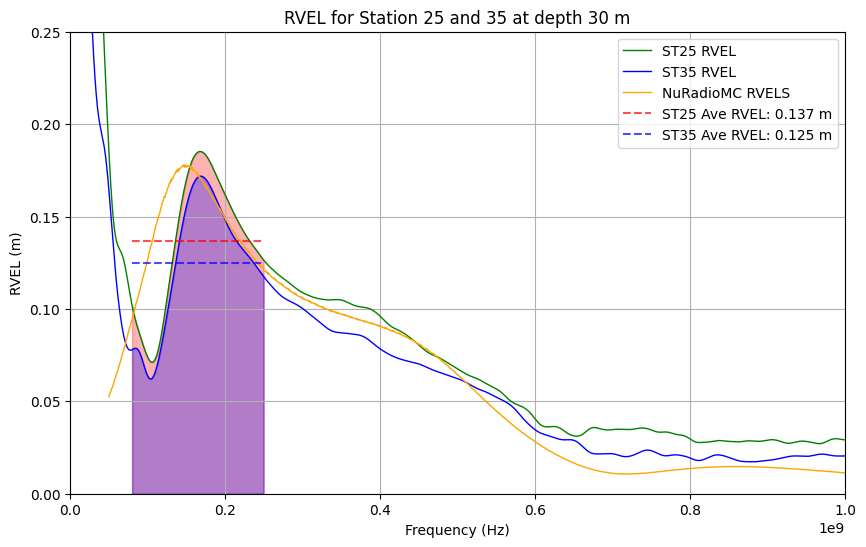

In [18]:
# draw a plot of the 10m depth for both dates on the same plot and shade the integrated area between 200 and 300Hz
# depths = the depths which appear in both lists
depths_aug_2 = []
depths_aug_4 = []
for net in vpol_aug_2:
    depth = int(net['name'].split('_')[-1][:-1])  # get the depth in meters as an integer
    depths_aug_2.append(depth)
for net in vpol_aug_4:
    depth = int(net['name'].split('_')[-1][:-1])  # get the depth in meters as an integer
    depths_aug_4.append(depth)
# find the depths which appear in both lists
depths = list(set(depths_aug_2) & set(depths_aug_4))
depths.sort()

f_low = 80e6
f_high = 250e6

depth = 30
if not update:
    net_aug_2 = next(net for net in vpol_aug_2 if int(net['name'].split('_')[-1][:-1]) == depth)
    net_aug_4 = next(net for net in vpol_aug_4 if int(net['name'].split('_')[-1][:-1]) == depth)
    plt.figure(figsize=(10, 6))
    plt.plot(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], label='ST25 RVEL', linewidth=1, color='green')
    plt.plot(net_aug_4['frequency'], net_aug_4['smoothed_RVEL'], label='ST35 RVEL', linewidth=1, color='blue')
    # shade the area between 200 and 300 MHz for both curves
    plt.fill_between(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], where=(net_aug_2['frequency'] >= f_low) & (net_aug_2['frequency'] <= f_high), color='red', alpha=0.3)
    plt.fill_between(net_aug_4['frequency'], net_aug_4['smoothed_RVEL'], where=(net_aug_4['frequency'] >= f_low) & (net_aug_4['frequency'] <= f_high), color='blue', alpha=0.3)
    # plot the NuRadioMC RVELs
    NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
    plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')
    # draw a horizontal line at the average RVEL between 200 and 300 MHz for both curves
    ave_RVEL_aug_2 = np.mean(net_aug_2['smoothed_RVEL'][(net_aug_2['frequency'] >= f_low) & (net_aug_2['frequency'] <= f_high)])
    ave_RVEL_aug_4 = np.mean(net_aug_4['smoothed_RVEL'][(net_aug_4['frequency'] >= f_low) & (net_aug_4['frequency'] <= f_high)])
    # draw the line between 200 and 300 MHz
    plt.hlines(ave_RVEL_aug_2, f_low, f_high, colors='red', linestyles='--', label=f'ST25 Ave RVEL: {ave_RVEL_aug_2:.3f} m', alpha=0.7)
    plt.hlines(ave_RVEL_aug_4, f_low, f_high, colors='blue', linestyles='--', label=f'ST35 Ave RVEL: {ave_RVEL_aug_4:.3f} m', alpha=0.7)

    plt.title(f'RVEL for Station 25 and 35 at depth {depth} m')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('RVEL (m)')
    plt.xlim(0, 1e9)
    plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
    plt.grid()
    plt.legend()
    plt.savefig(f'{dir}/vpol aug2 vs aug4 RVEL at {depth}m with shaded area {f_low}MHz-{f_high}MHz.png', dpi=300, bbox_inches='tight')
    # plt.close()


In [ ]:
# draw a plot of the 37m depth for net_aug_2 and NuRadio on the same plot and shade the integrated area between f_low and f_high
f_low = 80e6
f_high = 250e6
depth = 37
if not update:
    net_aug_2 = next(net for net in vpol_aug_2 if int(net['name'].split('_')[-1][:-1]) == depth)
    plt.figure(figsize=(10, 6))
    plt.plot(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], label='ST25 RVEL', linewidth=1, color='green')
    # shade the area between f_low and f_high for both curves
    plt.fill_between(net_aug_2['frequency'], net_aug_2['smoothed_RVEL'], where=(net_aug_2['frequency'] >= f_low) & (net_aug_2['frequency'] <= f_high), color='red', alpha=0.3)
    # plot the NuRadioMC RVELs
    NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
    plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='orange')
    # shade the area between f_low and f_high for NuRadio
    plt.fill_between(ff / units.Hz, np.abs


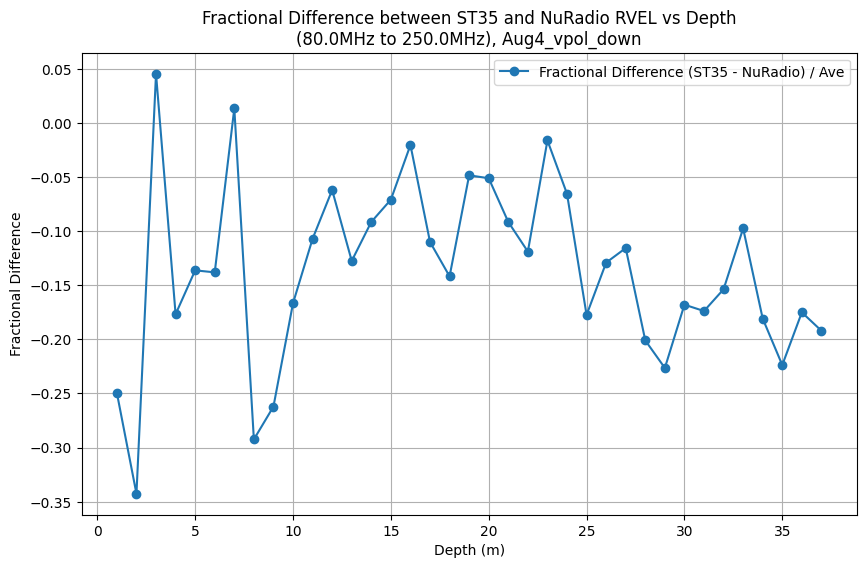

In [17]:
network_list =  hpol_down_aug_4
# network_list = hpol_up
network_list = vpol_aug_4
# network_list = vpol_aug_2

# hpol_down_networks_aug_4 = [net for net in networks_aug_4 if 'hpol_down' in net.name]
# hpol_up_networks_aug_4 = [net for net in networks_aug_4 if 'hpol_up' in net.name]
# vpol_networks_aug_4 = [net for net in networks_aug_4 if 'vpol' in net.name]


lower_frq = 80e6
upper_frq = 250e6

# calculate the fractional difference between the Aug4 RVEL and the NuRadio RVEL for each depth
# fractional difference = (RVEL_Aug4 - RVEL_NuRadio) / ave(RVEL_Aug4, RVEL_NuRadio)
# then plot the fractional difference vs depth

# name = network_list[0]['name']  # get the station name from the last network processed
# print(name)
if not update:
    frac_diffs = []
    depths = []
    # for net in vpol_aug_4:
    for net in network_list:
        name = net['name']
        depth = int(name.split('_')[-1][:-1])  # get the depth in meters as an integer
        depths.append(depth)
        # print(f'Calculating fractional difference for {name} at depth {depth} m')

        # integrate using the trapezoidal rule
        area_aug_4 = np.trapezoid(net['smoothed_RVEL'][(net['frequency'] >= lower_frq) & (net['frequency'] <= upper_frq)],
                                  net['frequency'][(net['frequency'] >= lower_frq) & (net['frequency'] <= upper_frq)])
        ave_RVEL_aug_4 = area_aug_4 / (upper_frq - lower_frq)

        # get the NuRadio RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 3.5in center n=1.74']
        area_nu = np.trapezoid(np.abs(NuRadio_VELS['theta'][(ff >= lower_frq * units.Hz) & (ff <= upper_frq * units.Hz)]),
                               ff[(ff >= lower_frq * units.Hz) & (ff <= upper_frq * units.Hz)] / units.Hz)
        # print(f'area_nu: {area_nu}, frq range: {(upper_frq - lower_frq) * units.Hz}')
        # print(f'area_nu: {area_nu}, frq range: {(upper_frq - lower_frq)}')

        # print(f'area_aug_4: {area_aug_4}, frq range: {upper_frq - lower_frq}')
        # ave_RVEL_nu = area_nu / ((upper_frq - lower_frq) * units.Hz)
        ave_RVEL_nu = area_nu / ((upper_frq - lower_frq))

        frac_diff = (ave_RVEL_aug_4 - ave_RVEL_nu) / ((ave_RVEL_aug_4 + ave_RVEL_nu) / 2)
        frac_diffs.append(frac_diff)
        # print(f"Depth: {depth} m, ST35 Ave RVEL: {ave_RVEL_aug_4:.4f} m, NuRadio Ave RVEL: {ave_RVEL_nu:.4f} m, Fractional Difference: {frac_diff:.4f}\n")

    plt.figure(figsize=(10, 6))
    plt.plot(depths, frac_diffs, label='Fractional Difference (ST35 - NuRadio) / Ave', marker='o')
    plt.title(f'Fractional Difference between ST35 and NuRadio RVEL vs Depth\n({lower_frq/1e6}MHz to {upper_frq/1e6}MHz), {name[:-4]}')
    plt.xlabel('Depth (m)')
    plt.ylabel('Fractional Difference')
    plt.grid()
    plt.legend()
    plt.savefig(f'{dir}/ST35 and NuRadio Fractional Difference vs depth {lower_frq/1e6}MHz to {upper_frq/1e6}MHz - {name[:-3]}.png', dpi=300, bbox_inches='tight')
    # plt.close()


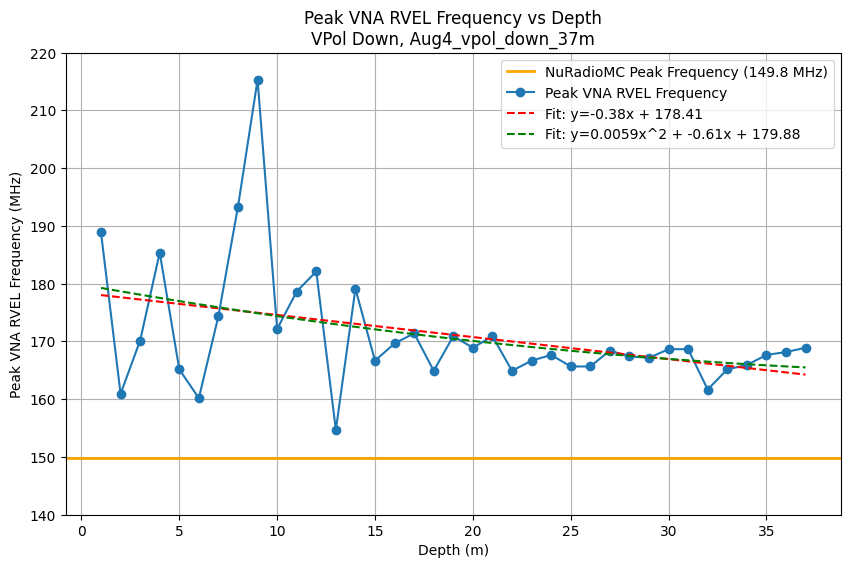

In [14]:
# plot how the peak VNA frequency changes with depth for vpol
depths = [int(peak[0].split('_')[-1][:-1]) for peak in vpol_peaks]  # get the depths in meters as integers
peak_freqs = [peak[1] for peak in vpol_peaks]
peak_RVELs = [peak[2] for peak in vpol_peaks]
plt.figure(figsize=(10, 6))

#plot a line at the NuRadio peak frequency, 149.8 MHz
plt.axhline(149.8, color='orange', linestyle='-', label='NuRadioMC Peak Frequency (149.8 MHz)', alpha=1, linewidth=2)

plt.plot(depths, np.array(peak_freqs) / 1e6, label='Peak VNA RVEL Frequency', marker='o')

# fit a curve to the data
z = np.polyfit(depths, np.array(peak_freqs) / 1e6, 1)
p = np.poly1d(z)
plt.plot(depths, p(depths), "r--", label=f'Fit: y={z[0]:.2f}x + {z[1]:.2f}')

z2 = np.polyfit(depths, np.array(peak_freqs) / 1e6, 2)
p2 = np.poly1d(z2)
plt.plot(depths, p2(depths), "g--", label=f'Fit: y={z2[0]:.4f}x^2 + {z2[1]:.2f}x + {z2[2]:.2f}')

plt.title(f'Peak VNA RVEL Frequency vs Depth\nVPol Down, {name}')
plt.xlabel('Depth (m)')
plt.ylabel('Peak VNA RVEL Frequency (MHz)')
plt.ylim(140, 220)
plt.grid()
plt.legend()
plt.savefig(f'{dir}/peak VNA RVEL frequency vs depth - vpol_down {name}.png', dpi=300, bbox_inches='tight')

#TODO: see if there's a better way to calculate the peak frequency, there is probably some error introduced by smoothing

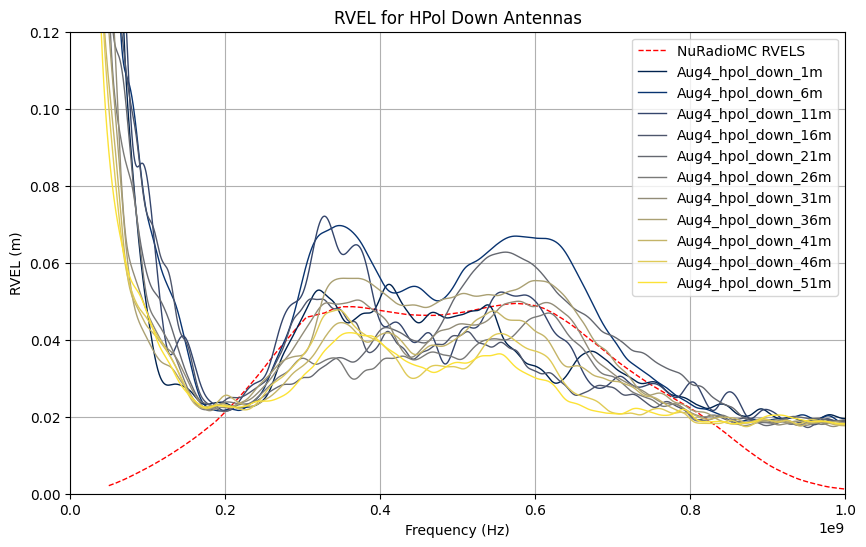

In [15]:
# for the hpol down, plot every 5th RVEL on the same plot for comparison
dir = 'RVEL Plots'

# use the plasma perceptually uniform sequential colormap
cmap = plt.get_cmap('cividis')

if update:
    plt.figure(figsize=(10, 6))
    # plot the NuRadioMC RVELs
    NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
    plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1, color='r', linestyle='--')

    for i, net in enumerate(hpol_down_aug_4[::5]):  # plot every 5th network
        # name = net['name'][5:]  # remove the Aug4_ part of the name
        name = net['name']
        color = cmap(i / (len(hpol_down_aug_4) / 5))  # get a color from the colormap
        plt.plot(net['frequency'], net['smoothed_RVEL'], label=name, linewidth=1, color=color)


    plt.title('RVEL for HPol Down Antennas')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('RVEL (m)')
    plt.xlim(0, 1e9)
    plt.ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
    plt.grid()
    plt.legend()
    plt.savefig(f'{dir}/selected hpol down_RVEL.png', dpi=300, bbox_inches='tight')
    # plt.close()

In [16]:
# do the same for vpol including the peak frequency markers
dir = 'RVEL Plots'
cmap = plt.get_cmap('cividis')

if update:
    plt.figure(figsize=(10, 6))
    # plot the NuRadioMC RVELs
    NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
    plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1, color='r', linestyle='--')

    for i, net in enumerate(vpol_aug_4[::5]):  # plot every 2nd network
        # name = net['name'][5:]  # remove the Aug4_ part of the name
        name = net['name']
        color = cmap(i / (len(vpol_aug_4) / 5))  # get a color from the colormap
        plt.plot(net['frequency'], net['smoothed_RVEL'], label=name, linewidth=1, color=color)

        # find the peak VNA RVEL above 100 MHz and draw a vertical line there with a label for the frequency
        peak_index = np.argmax(net['smoothed_RVEL'][net['frequency'] >= 100e6])
        peak_freq = net['frequency'][net['frequency'] >= 100e6][peak_index]
        peak_RVEL = net['smoothed_RVEL'][net['frequency'] >= 100e6][peak_index]
        # plt.axvline(peak_freq, color=color, linestyle='--', alpha=0.3)
        # plt.text(peak_freq + 10e6, peak_RVEL + 0.005, f'{peak_freq/1e6:.1f} MHz', rotation=90, color=color, alpha=0.7)

    # find the peak NuRadio RVEL above 100 MHz and draw a vertical line there with a label for the frequency
    peak_index_nu = np.argmax(np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz]))
    peak_freq_nu = ff[ff >= 100 * units.MHz][peak_index_nu] / units.Hz
    peak_RVEL_nu = np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz][peak_index_nu])
    plt.axvline(peak_freq_nu, color='red', linestyle='--', alpha=0.7)
    plt.text(peak_freq_nu - 5.25e6, peak_RVEL_nu + 0.02, f'Simulated Peak\n\n     {peak_freq_nu/1e6:.1f} MHz', rotation=90, color='red', alpha=0.7)
    plt.title('RVEL for VPol Down Antennas')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('RVEL (m)')
    plt.xlim(0.05e9, 0.25e9)
    plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
    plt.grid()
    plt.legend()
    plt.savefig(f'{dir}/selected vpol down_RVEL.png', dpi=300, bbox_inches='tight')
    plt.close()

In [17]:
# calculate the full width half max for each of the vpol NuRadioMC RVELS
# this is the frequency range where the RVEL is greater than half the maximum RVEL
# it is calculated for each depth, not the maximum of all depths





In [18]:
# TODO: do a 2 column plot showing hpol up and down side by side for comparison
dir = 'RVEL Plots'

if update:
    # create a subplot 2 columns wide and len(hpol_up) rows tall
    fig, axs = plt.subplots(len(hpol_up_aug_4) - 1, 2, figsize=(15, 3 * len(hpol_up_aug_4)), sharex=True)
    for i in range(0, len(hpol_up_aug_4) - 1):
        net_up = hpol_up_aug_4[i + 1]
        net_down = hpol_down_aug_4[i]
        # name_down = net_down['name'][5:]  # remove the Aug4_ part of the name
        # name_up = net_up['name'][5:]  # remove the Aug4_ part of the name
        name_down = net_down['name']
        name_up = net_up['name']

        # print(f'i: {i}, name_down: {name_down}, name_up: {name_up}')

        # print(f'Plotting for {name_down} and {name_up}')
        axs[i, 0].plot(net_down['frequency'], net_down['smoothed_RVEL'], label=net_down['name'] + ' RVEL (smoothed)', linewidth=1, color='red')
        axs[i, 1].plot(net_up['frequency'], net_up['smoothed_RVEL'], label=net_up['name'] + ' RVEL (smoothed)', linewidth=1, color='red')
        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
        axs[i, 0].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        axs[i, 1].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        axs[i, 0].set_title(f'RVEL for {name_down}')
        axs[i, 1].set_title(f'RVEL for {name_up}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i, 0].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i, 0].set_xlim(0, 1e9)
        axs[i, 1].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i, 0].set_xlabel('Frequency (Hz)')
        axs[i, 1].set_xlabel('Frequency (Hz)')
        axs[i, 0].set_ylabel('RVEL (m)')
        axs[i, 1].set_ylabel('RVEL (m)')
        axs[i, 0].tick_params(axis='x', which='both', labelbottom=True)
        axs[i, 1].tick_params(axis='x', which='both', labelbottom=True)
        axs[i, 0].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        axs[i, 1].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        axs[i, 0].grid()
        axs[i, 1].grid()
        axs[i, 0].legend()
        axs[i, 1].legend()
    plt.tight_layout()
    plt.savefig(f'{dir}/all hpol up vs down_RVEL.png', dpi=300, bbox_inches='tight')
    plt.close()

In [19]:
# do the above but plot them on top of each other for comparison

if update:
    # create a subplot 1 column wide and len(hpol_up) rows tall
    fig, axs = plt.subplots(len(hpol_up_aug_4) - 1, 1, figsize=(10, 3 * len(hpol_up_aug_4)), sharex=True)
    for i in range(0, len(hpol_up_aug_4) - 1):
        net_up = hpol_up_aug_4[i + 1]
        net_down = hpol_down_aug_4[i]
        # name_down = net_down['name'][5:]  # remove the Aug4_ part of the name
        # name_up = net_up['name'][5:]  # remove the Aug4_ part of the name
        name_down = net_down['name']
        name_up = net_up['name']

        # print(f'i: {i}, name_down: {name_down}, name_up: {name_up}')

        # print(f'Plotting for {name_down} and {name_up}')
        axs[i].plot(net_down['frequency'], net_down['smoothed_RVEL'], label=net_down['name'] + ' RVEL Down (smoothed)', linewidth=1, color='red')
        axs[i].plot(net_up['frequency'], net_up['smoothed_RVEL'], label=net_up['name'] + ' RVEL Up (smoothed)', linewidth=1, color='blue')
        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
        axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        axs[i].set_title(f'RVEL for {name_down} and {name_up}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        axs[i].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()
    plt.tight_layout()
    plt.savefig(f'{dir}/all hpol up vs down_RVEL_overlay.png', dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# do the above but plot them individually

if not update:
    for i in range(0, len(hpol_up_aug_4) - 1):
        net_up = hpol_up_aug_4[i + 1]
        net_down = hpol_down_aug_4[i]
        # name_down = net_down['name'][5:]  # remove the Aug4_ part of the name
        # name_up = net_up['name'][5:]  # remove the Aug4_ part of the name
        name_down = net_down['name']
        name_up = net_up['name']

        plt.figure(figsize=(10, 6))
        plt.plot(net_down['frequency'], net_down['smoothed_RVEL'], label=net_down['name'] + ' RVEL Down (smoothed)', linewidth=1, color='red')
        plt.plot(net_up['frequency'], net_up['smoothed_RVEL'], label=net_up['name'] + ' RVEL Up (smoothed)', linewidth=1, color='blue')
        # plot the NuRadioMC RVELs
        NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
        plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        plt.title(f'RVEL for {name_down} and {name_up}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('RVEL (m)')
        plt.xlim(0, 1e9)
        plt.ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{dir}/hpol up vs down_RVEL_overlay_{name_down}.pdf', dpi=300, bbox_inches='tight')
        plt.close()